# Logistic Regressions And Decision Trees - 24 May 2017
----------------------------
## Summary
1. PCA for Explaratory Data Analysis: using magnitude timeseries
2. Balance out data + ROC Curves
3. kNN classifier: varying number of neighbours

-----------------------------------------------------------

#### Imports 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn import neighbors

In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### Helper functions

In [4]:
def get_data(data_dict, data_id):
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    data = df.iloc[:,1:]
    target = df.fall
    return data_name, data, target

In [5]:
# normalises train data set as (X - mean / stdev) and applies the same scaling to test dataset 
def train_test_normalise(x_train, x_test):
    mean = x_train.mean().T
    std = x_train.std().T
    return ((x_train - mean)/std,(x_test - mean)/std) 

In [6]:
# balance data by duplicating falls
def balance_data_by_duplicating(X, y, num_copies = 1): 
    dd = X.copy(deep=True)
    dd['fall'] = y
    falls_data = dd[dd.fall == 1]
    for i in range(0,num_copies):
        dd = dd.append(falls_data)
    #X_new = dd.iloc[:,1:]
    y_new = dd['fall']
    dd = dd.drop('fall',axis = 1)
    return dd, y_new  

In [7]:
# returns labelled model coefficients 
def model_coefficients(clf, features):
    model_coeff = pd.DataFrame(clf.coef_,columns=features, index = ['value']).T
    model_coeff['abs_value'] = abs(model_coeff.value)
    model_coeff = model_coeff.sort_values('abs_value', ascending = False)
    return model_coeff

In [8]:
def model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='', data_name='', info=''):
    result = pd.DataFrame({'classifier': clf_name,
                           'data_set': data_name,
                           'num_feat': X_train.shape[1],  
                           'info': info,
                           'train_accuracy': metrics.accuracy_score(y_train, clf.predict(X_train)), 
                           'train_precision': metrics.precision_score(y_train, clf.predict(X_train)), 
                           'train_recall': metrics.recall_score(y_train, clf.predict(X_train)),
                           'test_accuracy': metrics.accuracy_score(y_test, clf.predict(X_test)), 
                           'test_precision': metrics.precision_score(y_test, clf.predict(X_test)), 
                           'test_recall': metrics.recall_score(y_test, clf.predict(X_test)),
                          },
                          index = [0])
    columns = ['classifier','data_set','num_feat','test_accuracy','test_precision','test_recall',
              'train_accuracy','train_precision','train_recall','info']
    result = result[columns]
    return result                                                                   

#### Read in data dictionary for available datasets

<a id='datasets'></a>

In [9]:
data_dict = pd.read_csv('data/data_dict.csv', index_col = 0)
data_dict

,name,desc,num_features,file,normalise
id,,,,,
1,magn_stats,Summary statistics on acceleration magnitude,8,data/magn_stats.csv,1
2,triax_stats,Summary statistics on triaxial acceleration,24,data/triax_stats.csv,1
3,magn_ts,Time series of acceleration magnitude,51,data/magn_ts.csv,0
4,triax_ts,Time series of triaxial accelaration - raw data,153,data/triax_ts.csv,0


--------------------
## PCA using timeseries of acceleration magnitude

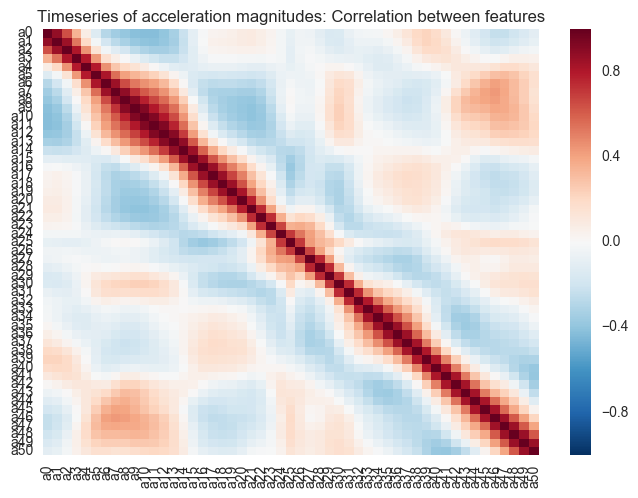

In [10]:
# Time series of acceleration magnitudes : correlations between features
data_name, data, target = get_data(data_dict,data_id = 3)
ax = plt.axes()
sns.heatmap(data.corr(),ax = ax)
ax.set_title('Timeseries of acceleration magnitudes: Correlation between features');

As one would expect the timeseries is autocorrelated : neighbouring points are highly correlated

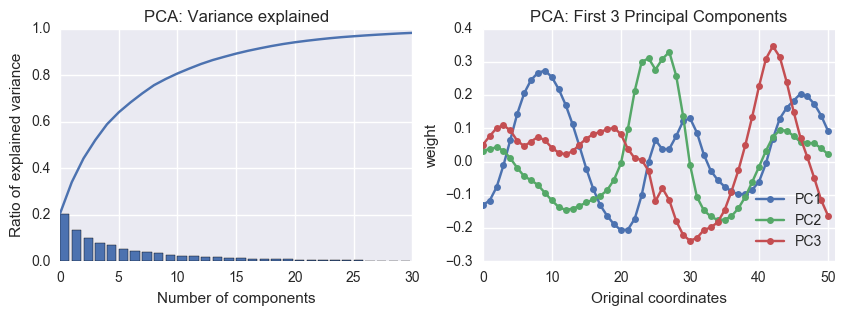

In [11]:
# PCA
pca = PCA()
pca.fit(data)
var_explained = pca.explained_variance_ratio_

# plot results
fig, (ax1,ax2) = plt.subplots(1,2, figsize = [10,3])

# plot explained variance
x = range(0, len(var_explained))
ax1.bar(x, var_explained)
ax1.plot(x, np.cumsum(var_explained)) 
ax1.set_title("PCA: Variance explained")
ax1.set_xlabel("Number of components")
ax1.set_ylabel('Ratio of explained variance')
ax1.set_ylim(0,1);
ax1.set_xlim(0,30);

#plot first principal components
n_components = 3
y = pca.components_
for i in range(0,n_components):
    ax2.plot(y[i], marker = 'o', markersize = 5, label = 'PC{0}'.format(i+1) )
ax2.set_title('PCA: First {0} Principal Components'.format(n_components))
ax2.set_xlabel('Original coordinates')
ax2.set_ylabel('weight')
ax2.set_xlim(0,len(var_explained));
ax2.legend(loc="lower right");

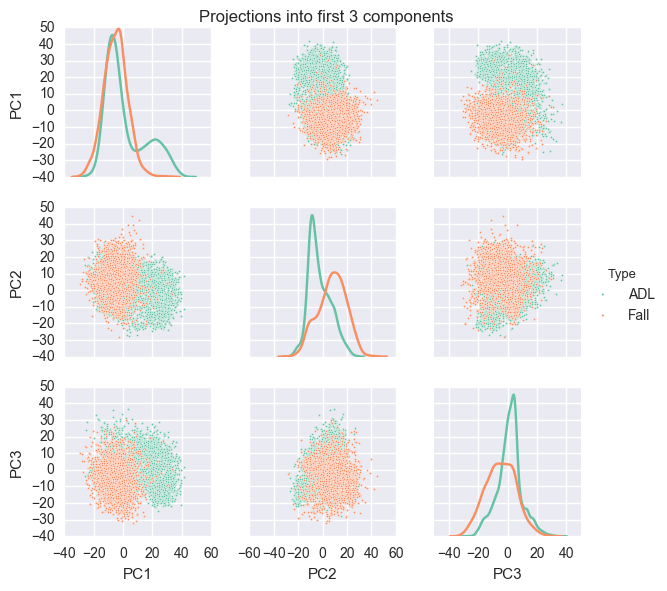

In [12]:
# Project the original data into PC and plot distributions
pca = PCA(n_components=3)
pca.fit(data)
data_new = pd.DataFrame(pca.transform(data), columns = ['PC1', 'PC2','PC3'])
data_new['isFall'] = target
data_new['Type'] = 'ADL'
data_new.loc[data_new.isFall == 1,'Type'] = 'Fall'
data_new = data_new.drop('isFall', axis=1)
g = sns.pairplot(data_new, hue="Type", palette="Set2", diag_kind="kde",size=2,plot_kws={"s": 3})
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Projections into first 3 components');

-------------
## Logistic regressions : Balanced data +  ROC curves

In [13]:
# regularisation params
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
param_grid = {'C': Cs, 'penalty':['l1','l2']}

,classifier,data_set,num_feat,test_accuracy,test_precision,test_recall,train_accuracy,train_precision,train_recall,info
0,LogRegr,magn_stats - Original,8,0.858874,0.770370,0.604651,0.872593,0.795031,0.633037,"{'penalty': 'l1', 'C': 0.1}"
0,LogRegr,magn_stats - Balanced,8,0.829294,0.623669,0.765988,0.835750,0.624805,0.792285,"{'penalty': 'l1', 'C': 1}"
0,LogRegr,triax_stats - Original,24,0.942979,0.920382,0.840116,0.956026,0.941239,0.871414,"{'penalty': 'l2', 'C': 1}"
0,LogRegr,triax_stats - Balanced,24,0.930150,0.830645,0.898256,0.940100,0.844062,0.920870,"{'penalty': 'l1', 'C': 10}"
0,LogRegr,magn_ts - Original,51,0.919102,0.888702,0.765988,0.924649,0.898851,0.773492,"{'penalty': 'l1', 'C': 1}"
0,LogRegr,magn_ts - Balanced,51,0.885246,0.736434,0.828488,0.895412,0.748910,0.849654,"{'penalty': 'l2', 'C': 1}"


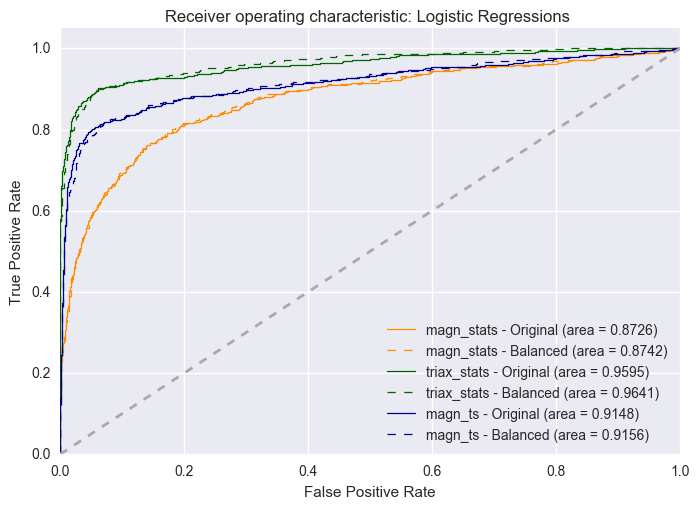

In [14]:
res_store = pd.DataFrame()
colors = ['darkorange', 'darkgreen', 'darkblue']
for data_id in [1,2,3]:
    data_name, data, target = get_data(data_dict,data_id)
    need_normalise = data_dict.get_value(data_id,'normalise') 
    
    #split into training and test and normalise if required
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
    if (need_normalise == 1): 
        X_train, X_test = train_test_normalise(X_train, X_test)
    #balance data by adding more falls 
    X_train_balanced, y_train_balanced = balance_data_by_duplicating(X_train, y_train, num_copies = 2)  
    
    # train classifier on the data as it is ( unbalanced) 
    data_desc = data_name + ' - Original'
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train, y_train)
    y_score = clf.decision_function(X_test)
    #   record results
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='LogRegr',data_name=data_desc, info=str(clf.best_params_))
    res_store = pd.concat([res_store, mm])
    #   plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label= data_desc + ' (area = %0.4f)' % roc_auc, color = colors[data_id - 1], lw = 0.9)    
    
    # train classifier on balanced data
    data_desc = data_name + ' - Balanced'
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train_balanced, y_train_balanced)
    y_score_balanced = clf.decision_function(X_test)
    # record results
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='LogRegr', data_name=data_desc, info=str(clf.best_params_))
    res_store = pd.concat([res_store, mm])
    # plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score_balanced)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr,  label= data_desc + ' (area = %0.4f)' % roc_auc, color = colors[data_id - 1],  linestyle='--', lw = 0.9)
# Decorate plot
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Logistic Regressions ')
plt.legend(loc="lower right");  
res_store

--------
## Decision Trees : Using balanced data

In [15]:
param_grid = {'max_depth': np.arange(3,15,2), 'min_samples_split': np.arange(20,80,5)}

In [16]:
res_store_2 = pd.DataFrame()
for data_id in [1,2,3]:
    data_name, data, target = get_data(data_dict,data_id)
    need_normalise = data_dict.get_value(data_id,'normalise') 
    
    #split into training and test and normalise if required
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
    if (need_normalise == 1): 
        X_train, X_test = train_test_normalise(X_train, X_test)
    #balance data by adding more falls 
    X_train_balanced, y_train_balanced = balance_data_by_duplicating(X_train, y_train, num_copies = 2)  
    
    # train classifier on the data as it is ( unbalanced) 
    data_desc = data_name + ' - Original'
    clf = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv = 5)
    clf.fit(X_train, y_train)
    #   record results
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='Tree',data_name=data_desc, info=str(clf.best_params_))
    res_store_2 = pd.concat([res_store_2, mm])
   
    
    # train classifier on balanced data
    data_desc = data_name + ' - Balanced'
    clf = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv = 5)
    clf.fit(X_train_balanced, y_train_balanced)
    # record results
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='Tree', data_name=data_desc, info=str(clf.best_params_))
    res_store_2 = pd.concat([res_store_2, mm])

res_store_2

,classifier,data_set,num_feat,test_accuracy,test_precision,test_recall,train_accuracy,train_precision,train_recall,info
0,Tree,magn_stats - Original,8,0.881326,0.830540,0.648256,0.915617,0.901961,0.727992,"{'min_samples_split': 40, 'max_depth': 7}"
0,Tree,magn_stats - Balanced,8,0.851746,0.686301,0.728198,0.951509,0.873957,0.932740,"{'min_samples_split': 20, 'max_depth': 13}"
0,Tree,triax_stats - Original,24,0.942623,0.917591,0.841570,0.966484,0.962766,0.895153,"{'min_samples_split': 20, 'max_depth': 7}"
0,Tree,triax_stats - Balanced,24,0.955453,0.920777,0.895349,0.988353,0.965184,0.987141,"{'min_samples_split': 20, 'max_depth': 13}"
0,Tree,magn_ts - Original,51,0.907698,0.887884,0.713663,0.948182,0.949037,0.828882,"{'min_samples_split': 30, 'max_depth': 9}"
0,Tree,magn_ts - Balanced,51,0.893086,0.796636,0.757267,0.977419,0.948141,0.958457,"{'min_samples_split': 20, 'max_depth': 13}"


---------------
## K nearest neighbours

### Controlling model complexity by varying number of neighbours

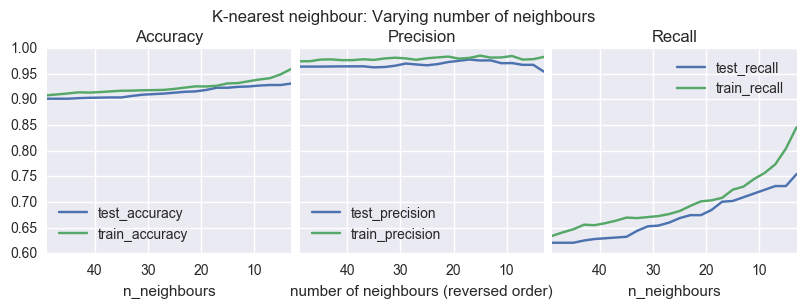

In [17]:
# Using timeseries of acceleration magnitude
data_id = 3
data_name, data, target = get_data(data_dict,data_id)
   
#split into training and test and normalise if required
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)

# vary number of neighbours and test the model
n_neighbours = np.arange(3,50,2)
store = pd.DataFrame()
for i in n_neighbours:
    clf = neighbors.KNeighborsClassifier(i)
    clf.fit(X_train, y_train)
    mm = model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='Tree', 
                        data_name=data_name, info=i)
    store = pd.concat([store, mm])

store['n_neighbours'] = store['info']
store = store.set_index('n_neighbours')
# plot comparison 
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True, figsize = (8,3))
store[['test_accuracy','train_accuracy']].plot(title = "Accuracy", ax = ax1)
store[['test_precision','train_precision']].plot(title = "Precision", ax = ax2)
store[['test_recall','train_recall']].plot(title = "Recall", ax = ax3)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(top=0.85)
fig.suptitle("K-nearest neighbour: Varying number of neighbours")
ax1.set_xlim(max(n_neighbours),min(n_neighbours))
ax2.set_xlim(max(n_neighbours),min(n_neighbours))
ax3.set_xlim(max(n_neighbours),min(n_neighbours))
ax2.set_xlabel('number of neighbours (reversed order)');

### Use cross validation to find number of neighbours

In [21]:
param_grid = {'n_neighbors': np.arange(3,10,2)}

In [24]:
%%time
res_store_3 = pd.DataFrame()
for data_id in [1,2,3]:
    data_name, data, target = get_data(data_dict,data_id)
    need_normalise = data_dict.get_value(data_id,'normalise') 
    print data_name
    
    #split into training and test and normalise if required
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
    if (need_normalise == 1): 
        X_train, X_test = train_test_normalise(X_train, X_test)
    #balance data by adding more falls 
    X_train_balanced, y_train_balanced = balance_data_by_duplicating(X_train, y_train, num_copies = 2)  
    
    # train classifier on the data as it is ( unbalanced) 
    data_desc = data_name + ' - Original'
    clf = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv = 5)
    clf.fit(X_train, y_train)
    #   record results
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='kNN',data_name=data_desc, info=str(clf.best_params_))
    res_store_3 = pd.concat([res_store_3, mm])

res_store_3

magn_stats
triax_stats
magn_ts
CPU times: user 43.4 s, sys: 100 ms, total: 43.5 s
Wall time: 43.6 s


In [25]:
res_store_3

,classifier,data_set,num_feat,test_accuracy,test_precision,test_recall,train_accuracy,train_precision,train_recall,info
0,kNN,magn_stats - Original,8,0.894155,0.860037,0.678779,0.924887,0.934919,0.738872,{'n_neighbors': 7}
0,kNN,triax_stats - Original,24,0.960798,0.966129,0.870640,0.979796,0.990466,0.924827,{'n_neighbors': 3}
0,kNN,magn_ts - Original,51,0.930862,0.954044,0.754360,0.959353,0.982759,0.845697,{'n_neighbors': 3}


----------------------
## Results so far 

<a id='results'></a>

In [32]:
# Results sorted by model accuracy on test set
res = pd.concat([res_store, res_store_2, res_store_3])
res[['classifier', 'data_set', 'num_feat', 'test_accuracy', 'test_precision', 'test_recall']].sort_values('test_accuracy', ascending = False)

,classifier,data_set,num_feat,test_accuracy,test_precision,test_recall
0,kNN,triax_stats - Original,24,0.960798,0.966129,0.870640
0,Tree,triax_stats - Balanced,24,0.955453,0.920777,0.895349
0,LogRegr,triax_stats - Original,24,0.942979,0.920382,0.840116
0,Tree,triax_stats - Original,24,0.942623,0.917591,0.841570
0,kNN,magn_ts - Original,51,0.930862,0.954044,0.754360
0,LogRegr,triax_stats - Balanced,24,0.930150,0.830645,0.898256
0,LogRegr,magn_ts - Original,51,0.919102,0.888702,0.765988
0,Tree,magn_ts - Original,51,0.907698,0.887884,0.713663
0,kNN,magn_stats - Original,8,0.894155,0.860037,0.678779
0,Tree,magn_ts - Balanced,51,0.893086,0.796636,0.757267
